# S04 - Simulation de gestion des stocks (s, S)

Ce notebook fournit un exemple d'utilisation de `DataFrame` pour calculer la performances de la gestion des stocks en fonction de la demande estimée. L'objectif est de *comprendre* ce que fait chaque cellule de code. Le développer par vous-même nécessite du temps et de l'expérience, mais si vous comprenez globalement le processus et le code, cela suffit.

## Simulation de gestion des stocks à l'aide de pandas
Dans cet exercice, vous utiliserez la bibliothèque pandas pour simuler différentes politiques de gestion des stocks pour un horizon de planification d’un an.

### Étape 1 : Lecture des données
Importez la bibliothèque pandas sous l'alias `pd`. Importez le fichier CSV `DemandSimulation.csv` dans un `DataFrame` et sélectionnez la première colonne nommée `'Week'` comme index du `DataFrame`.

**Astuce :** vous pouvez définir la colonne d'index du `DataFrame` en utilisant le paramètre `index_col` de la fonction `read_csv()`. Consultez [cette page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) pour plus d'informations.

In [1]:
import pandas as pd

# Il s'agit d'un fichier csv qui est en ligne. Vous pouvez également le télécharger en cliquant sur le lien.
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/data/DemandScenarios.csv'
demand_scenario_df = pd.read_csv(url, index_col='Week')
demand_scenario_df.shape

(52, 3)

Affichez maintenant les 10 premières lignes de votre `DataFrame`. Vous pouvez voir que le fichier contient la première colonne sous forme d'index (semaines) et que chacune des colonnes suivantes contient une liste de demandes estimées pour chaque scénario.

In [2]:
demand_scenario_df.head(10)

,Scenario1,Scenario2,Scenario3
Week,,,
1,18,21,17
2,16,16,15
3,13,13,11
4,17,17,16
5,11,11,10
6,20,23,18
7,15,17,13
8,20,20,17
9,15,16,13


### Étape 2 : Simulation et génération d'un objet `DataFrame`
Maintenant, nous allons simuler différentes politiques de gestion des stocks basées sur le modèle $(s,S)$ pour un scénario de demande spécifique et analyser/visualiser les performances d’une politique donnée en fonction de ce scénario de demande spécifique.

> Le modèle de gestion des stocks min-max ou $(s,S)$ est l'un des systèmes de gestion des stocks les plus couramment utilisés dans la pratique. Voici les détails de ce système de gestion des stocks. Dans celui-ci, le min/max est appliqué à un système périodique où l'inventaire est vérifié périodiquement à chaque période (par exemple, une fois par jour ou une fois par semaine) (Notez que ce système peut également être appliqué dans un système de commande en temps réel, mais dans la pratique, les commandes seraient passées périodiquement).
> * Il y a deux paramètres qui doivent être déterminés pour contrôler le réapprovisionnement des stocks : $s$ qui représente le niveau de stock minimum (ou point de commande), et $S$ qui représente le niveau de stock cible souhaité.
> * **Au début de chaque période**, ce système vérifie en permanence la position de stock (stock actuel + stock en transit) du produit.
> * Si la position de stock descend en dessous du niveau minimum $s$, le système crée une commande pour augmenter la position de stock au niveau maximum $S$. La quantité de commande $Q$ est alors $Q = S - \text{position de stock}$ (rappelons que la position de stock = stock actuel + en transit). Cette quantité de commande arrive après le délai de livraison.

Dans cet exercice, vous allez créer un code qui simule les performances de votre gestion des stocks pour une politique $(s,S)$ donnée. Ce code doit renvoyer un objet `DataFrame` contenant les niveaux de stocks (au début et à la fin de chaque période), les commandes à passer et les commandes à recevoir à chaque période (semaine) de l'horizon de planification simulé. Voici quelques instructions.

Le code nécessitera les paramètres d'entrée suivants :
* La `Series` d'un scénario du `DataFrame`, qui contient les données de demande simulées pour ce scénario spécifique
* (nombre) niveau de stock initial au début de l'horizon de planification
* (nombre) délai en semaines
* (nombre) valeur $s$, c'est-à-dire le niveau de stock minimum
* (nombre) valeur $S$, c'est-à-dire le niveau de stock maximal

La sortie de votre code doit être un `DataFrame` avec 52 lignes (52 semaines) et cinq colonnes comme suit :
* `'Start_Inv'` : niveau de stock au début de chaque semaine
* `'Receipt'` : unités reçues chaque semaine
* `'Demand'` : demande se produisant chaque semaine (un scénario de `demand_scenario_df`)
* `'Ending_Inv'` : niveau de stock à la fin de chaque semaine
* `'Order'` : quantité commandée en unités

Notez que le niveau de stock peut être négatif si vous avez un arriéré (la demande est supérieure à la quantité disponible). Dans ce cas, la valeur négative est reportée sur une période ultérieure pour être satisfaite.

**Conseils :**
* Nous utilisons le paramètre `index` pour accéder à la liste des index du `DataFrame` que vous avez créé dans les exercices précédents.
* Nous initialisons la première ligne de la colonne `'Start_Inv'` comme le niveau de stock initial donné en entrée. Vous pouvez également initialiser les entrées `'Receipt'` à $0$ à partir du début de l'horizon de planification jusqu'à ce que la période de temps soit égale au délai d'exécution.
* Nous utilisons ensuite une boucle `for` pour parcourir l'horizon de planification et calculer les valeurs correspondantes pour `'Start_Inv'`, `'Receipt'`, `'Ending_Inv'` et `'Order'`.

Nous fournissons ici les entrées restantes requises pour la simulation

In [3]:
# Paramètres du modèle
init_inv = 27  # niveau de stock initial
lead_time = 2  # délai de livraison

# Paramètres pour définir la politique (s, S)
s_min = 25  # c'est le petit s
s_max = 70  # c'est le grand s

demand_series = demand_scenario_df['Scenario1']  # nous prenons ici le premier scénario
demand_series.head()

Week
1    18
2    16
3    13
4    17
5    11
Name: Scenario1, dtype: int64

Nous pouvons créer un DataFrame vide pour stocker les résultats

In [4]:
# créer un dataframe (vide) pour conserver les résultats
column_names = ['Start_Inv', 'Receipt', 'Demand', 'Ending_Inv', 'Order']
n_weeks = len(demand_series.index)
inv_dataframe = pd.DataFrame(index=range(1, n_weeks + 1), columns=column_names)
inv_dataframe.index.name ='Week'  # donner le nom de l'index au dataframe de sortie
inv_dataframe.head()

,Start_Inv,Receipt,Demand,Ending_Inv,Order
Week,,,,,
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN


Vous pouvez d'abord initialiser le stock initial et également définir les réceptions de commandes de la période < délai de livraison à zéro (si nous commandons maintenant, l'arrivée la plus proche se fera après le délai de livraison). Vous pouvez également définir la colonne de demande.

In [5]:
# initialisation des niveaux de stock actuels et réception de la commande jusqu'à t=lead_time
inv_dataframe.loc[1, 'Start_Inv'] = init_inv 
for t in range(1, lead_time + 1): 
    inv_dataframe.loc[t, 'Receipt'] = 0

# ajouter les valeurs à la colonne de demande de la série
inv_dataframe['Demand'] = demand_series
inv_dataframe.head()  # revoir le résultat

,Start_Inv,Receipt,Demand,Ending_Inv,Order
Week,,,,,
1,27,0,18,NaN,NaN
2,NaN,0,16,NaN,NaN
3,NaN,NaN,13,NaN,NaN
4,NaN,NaN,17,NaN,NaN
5,NaN,NaN,11,NaN,NaN


Maintenant, à chaque itération, nous devons calculer le stock de fin à $Inv_t$ à partir du stock de fin de la période précédente $Inv_{t-1}$, de la quantité reçue et de la demande en utilisant la conservation de flux suivante.

$Inv_{t}$ = $Inv_{t-1} + Receipt_{t} - Demand_{t}$

Notez que le stock de fin à la période $t$ est le stock initial à la période $t+1$. Là encore, le stock peut être négatif si vous avez un arriéré.

**Remarque :** veuillez examiner le code suivant pour comprendre le processus. Ce n'est pas grave si vous ne pouvez pas le développer à partir de zéro. L'objectif est de montrer à quoi ressemble le processus/code. Nous essayons de rendre les commentaires aussi explicites que possible.

In [6]:
inv_dataframe.loc[1:5]

,Start_Inv,Receipt,Demand,Ending_Inv,Order
Week,,,,,
1,27,0,18,NaN,NaN
2,NaN,0,16,NaN,NaN
3,NaN,NaN,13,NaN,NaN
4,NaN,NaN,17,NaN,NaN
5,NaN,NaN,11,NaN,NaN


In [7]:
# attribuer des valeurs aux entrées du dataframe
for t in range(1, n_weeks + 1):
    # calculer les niveaux de stock au début et à la fin de chaque période
    if t > 1: 
        # définir Start_Inv à t égal à Ending_Inv à t-1
        # ignorer t=1 puisque nous avons déjà Start_Inv à t=1
        inv_dataframe.loc[t, 'Start_Inv'] = inv_dataframe.loc[t - 1, 'Ending_Inv']
    
    # calculer la conservation de flux pour Ending_Inv de la période en cours
    inv_dataframe.loc[t, 'Ending_Inv'] = (inv_dataframe.loc[t, 'Start_Inv']
                                          + inv_dataframe.loc[t,'Receipt']
                                          - inv_dataframe.loc[t, 'Demand'])
        
    # calculer les commandes et les réceptions pour la période t
    # calculer le stock en transit (en suspens)
    # Remarque : pandas inclut le point final d'une tranche (ici, t-1)
    intransit_quantity = inv_dataframe.loc[max(1, t-lead_time+1):t-1, 'Order'].sum()
    # calculer la position de stock
    inv_position = inv_dataframe.loc[t, 'Ending_Inv'] + intransit_quantity
    if  inv_position < s_min:  # dans ce cas une commande doit être passée
        # créer une commande Q = s_max - position actuelle de stock
        inv_dataframe.loc[t, 'Order'] = s_max - inv_position 
        # vérifier si nous atteignons la fin du dataframe, sinon, nous ajoutons le reçu de commande après le délai de livraison
        if t + lead_time <= max(inv_dataframe.index):    
            inv_dataframe.loc[t + lead_time, 'Receipt'] = inv_dataframe.loc[t, 'Order']
    else:  # aucune commande n'est passée si 'Ending_Inv' >= s_min
        inv_dataframe.loc[t, 'Order'] = 0   
        if t + lead_time <= max(inv_dataframe.index):
            inv_dataframe.loc[t + lead_time, 'Receipt'] = 0  # aucune réception de commande dans les délais t+leadtime

Vous pouvez maintenant examiner les résultats.

In [8]:
print(f"(s, S) = ({s_min}, {s_max})")
inv_dataframe

(s, S) = (25, 70)


,Start_Inv,Receipt,Demand,Ending_Inv,Order
Week,,,,,
1,27,0,18,9,61
2,9,0,16,-7,0
3,-7,61,13,41,0
4,41,0,17,24,46
5,24,0,11,13,0
6,13,46,20,39,0
7,39,0,15,24,46
8,24,0,20,4,0
9,4,46,15,35,0


### Étape 3 : Traçage des données

Nous pouvons également visualiser les données directement à partir du dataframe en prenant une colonne.

<Axes: xlabel='Week'>

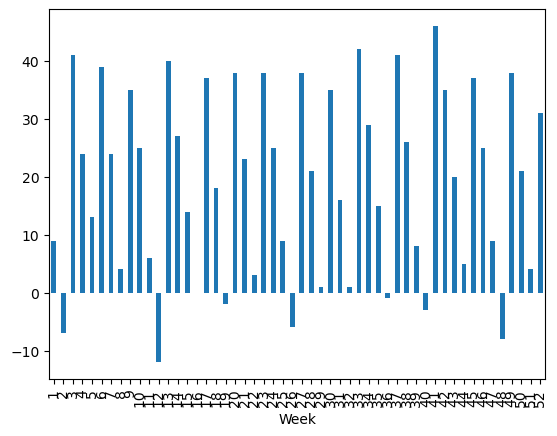

In [9]:
inv_dataframe["Ending_Inv"].plot(kind='bar')   # tracer des niveaux de stock

Cela peut même être fait pour plus d’une colonne.

<AxesSubplot:xlabel='Week'>

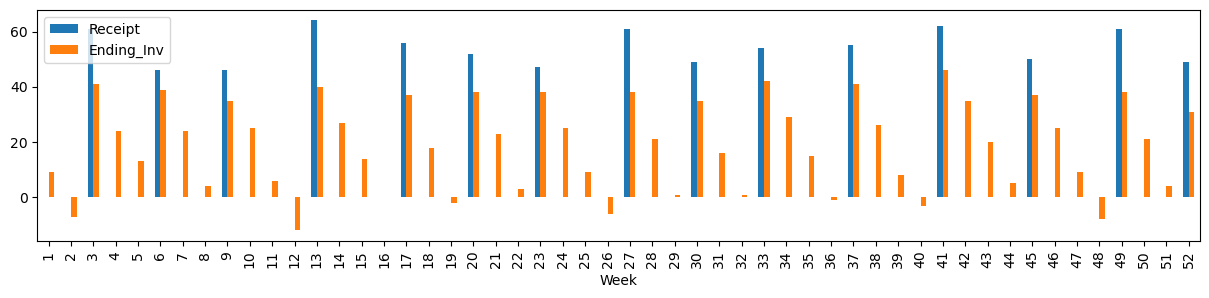

In [9]:
inv_dataframe[["Receipt", "Ending_Inv"]].plot(kind='bar', figsize=(15,3))   # tracer les inv et les commandes et redimensionner le tracé

Il est également possible de faire un histogramme.

Start_Inv     object
Receipt       object
Demand         int64
Ending_Inv    object
Order         object
dtype: object


<Axes: ylabel='Frequency'>

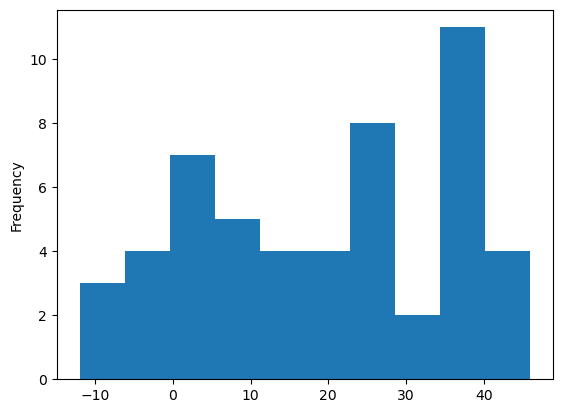

In [10]:
print(inv_dataframe.dtypes)
inv_dataframe = inv_dataframe.astype(float)  # nous devons appliquer cela sinon une erreur peut se produire car le type est `object`
inv_dataframe['Ending_Inv'].plot(kind='hist') 

### Étape 4 : Récapitulation des résultats
Nous pouvons également utiliser les méthodes DataFrame pour résumer les résultats.
Voir [cette page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.lt.html) pour plus de détails.

In [11]:
backlog_num = inv_dataframe['Ending_Inv'].lt(0).sum()
backlog_total_units = inv_dataframe['Ending_Inv'].loc[inv_dataframe['Ending_Inv'] < 0].sum()  # ce nombre est négatif
demand_total = inv_dataframe['Demand'].sum()
order_total = inv_dataframe['Order'].sum()
order_num = inv_dataframe['Order'].gt(0).sum()
inv_total_units = inv_dataframe['Ending_Inv'].loc[inv_dataframe['Ending_Inv'] > 0].sum()

print(f"Performances de (s, S) = ({s_min}, {s_max}) dans le scénario de demande : {demand_series.name}")
print(f"Nombre total de commandes = {order_num}, Quantité moyenne de commandes = {order_total / order_num:.2f}")
print(f"Stock moyen par semaine = {inv_total_units / n_weeks:.2f}")
print(f"Nombre moyen d'unités en attente par semaine = {abs(backlog_total_units / n_weeks):.2f}")
print(f"Nombre d'arriérés = {backlog_num}")
print(f"Niveau de service = {( 1 - backlog_num / n_weeks) * 100:.2f}%")  # % de fois où la demande est entièrement satisfaite
print(f"Taux de couverture = {(demand_total + backlog_total_units) / demand_total * 100:.2f}%")  # % de la quantité exécutée dans les délais

Performances de (s, S) = (25, 70) dans le scénario de demande : Scenario1
Nombre total de commandes = 15, Quantité moyenne de commandes = 54.20
Stock moyen par semaine = 19.92
Nombre moyen d'unités en attente par semaine = 0.75
Nombre d'incidents en attente = 7
Service level = 86.54%
Fill rate = 95.18%


### Jouer avec le code
Vous pouvez maintenant répéter le processus ci-dessus avec un scénario de demande différent (par exemple, en choisissant « Scénario 2 » ou « Scénario 3 » et en faisant varier les paramètres de contrôle des stocks « s_min » et « s_max » et en explorant les résultats).